In [11]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import geopy
from geopy.geocoders import ArcGIS

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# Загрузка словаря анализа тональности текста Natural Language Toolkit (NLTK)
nltk.downloader.download('vader_lexicon')

import time

from collections import Counter

import category_encoders as ce

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
from sklearn.model_selection import train_test_split   # Загружаем специальный инструмент для разбивки

import warnings
# Отключение отображения предупреждений
warnings.filterwarnings("ignore")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
hotels = pd.read_csv('data/hotels.csv')
hotels.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643


Задание 4.2

Сколько отелей представлено в наборе данных?

In [4]:
hotels['hotel_name'].value_counts()
print(f'Всего отелей: {len(hotels["hotel_name"].unique())}')

Всего отелей: 1492


Задание 4.3

Когда был оставлен самый свежий отзыв?

Когда был оставлен самый первый отзыв?

In [5]:
# Приведение типа данных к datetime
hotels['review_datetime'] = pd.to_datetime(hotels['review_date'])

In [6]:
hotels['review_datetime'].sort_values()
print(f'Cамый свежий отзыв: {hotels["review_datetime"].max()}')
print(f'Cамый первый отзыв: {hotels["review_datetime"].min()}')

Cамый свежий отзыв: 2017-08-03 00:00:00
Cамый первый отзыв: 2015-08-04 00:00:00


Задание 4.4

Сколько уникальных тегов представлено в наборе данных?

In [3]:
# Создаем список строк тегов
list_of_tags = hotels['tags'].tolist()

# Превращаем строки в списки
tags = []

for lst in list_of_tags:
    tags.append(eval(lst))
    
# Распаковка вложенных списков в один список
def flatten(container):
    for i in container:
        if isinstance(i, (list, tuple)):
            yield from flatten(i)
        else:
            yield i

flattened_list = list(flatten(tags))

# Получаем множество уникальных тегов
tags_set = set()

for i in  flattened_list:
    tags_set.add(i)

print(f'Уникальных тегов: {len(tags_set)}')

Уникальных тегов: 2368


Задание 4.5

Какой тег представлен в наибольшем числе отзывов?

In [13]:
print(Counter(flattened_list))

Counter({' Leisure trip ': 313593, ' Submitted from a mobile device ': 230778, ' Couple ': 189212, ' Stayed 1 night ': 145373, ' Stayed 2 nights ': 100263, ' Solo traveler ': 81235, ' Stayed 3 nights ': 72000, ' Business trip ': 61989, ' Group ': 49088, ' Family with young children ': 45836, ' Stayed 4 nights ': 35748, ' Double Room ': 26386, ' Standard Double Room ': 24151, ' Superior Double Room ': 23550, ' Family with older children ': 19802, ' Deluxe Double Room ': 18623, ' Double or Twin Room ': 16824, ' Stayed 5 nights ': 15611, ' Standard Double or Twin Room ': 13062, ' Classic Double Room ': 12716, ' Superior Double or Twin Room ': 10238, ' 2 rooms ': 9287, ' Stayed 6 nights ': 7399, ' Standard Twin Room ': 7325, ' Single Room ': 7227, ' Twin Room ': 6279, ' Stayed 7 nights ': 5549, ' Executive Double Room ': 4763, ' Classic Double or Twin Room ': 4576, ' Superior Twin Room ': 4540, ' Club Double Room ': 4485, ' Deluxe Double or Twin Room ': 4465, ' Queen Room ': 4071, ' Deluxe

1. Очистка данных от пропущенных значений

1.1 Очистка пропусков в координатах на основе использования библиотеки geopy. Восстанавливаем координаты.

In [10]:
# Очистка пропусков в координатах на основе использования библиотеки geopy. Восстанавливаем координаты.

geolocator = ArcGIS()

# Функция определения широты (latitude)
def geocode_lat(g_locator, address):
    location = g_locator.geocode(address)
    if location!=None:
      return location.latitude
    else:
      return np.NaN

# Фильтр строк в которых пропущенные значения 
filtered_lat = hotels[hotels['lat'].isna()]

# Применяем функцию к каждой строке
filtered_lat['lat'] = filtered_lat['hotel_address'].apply(lambda x:geocode_lat(geolocator,x))

# Заполняем пропуски в датасете
hotels = hotels.fillna(filtered_lat)

# Функция определения долготы (longitude)
def geocode_lng(g_locator, address):
    location = g_locator.geocode(address)
    if location!=None:
      return location.longitude
    else:
      return np.NaN

# Фильтр строк в которых пропущенные значения 
filtered_lng = hotels[hotels['lng'].isna()]

# Применяем функцию к каждой строке
filtered_lng['lng'] = filtered_lng['hotel_address'].apply(lambda x:geocode_lat(geolocator,x))

# Заполняем пропуски в датасете
hotels = hotels.fillna(filtered_lng)

In [11]:
# Сохраняем обработанный датасет
hotels.to_csv('data/hotels_new.csv', index=False, header=True)

2. Создание новых признаков.

2.1 Анализ текстовых отзывов (Sentiment analysis)

In [14]:
sentiments = SentimentIntensityAnalyzer()

# Создание новых признаков
hotels["Positive_n"] = [sentiments.polarity_scores(i)["pos"] for i in hotels["negative_review"]]
hotels["Negative_n"] = [sentiments.polarity_scores(i)["neg"] for i in hotels["negative_review"]]
hotels["Neutral_n"] = [sentiments.polarity_scores(i)["neu"] for i in hotels["negative_review"]]
hotels['Compound_n'] = [sentiments.polarity_scores(i)["compound"] for i in hotels["negative_review"]]
hotels["Positive_p"] = [sentiments.polarity_scores(i)["pos"] for i in hotels["positive_review"]]
hotels["Negative_p"] = [sentiments.polarity_scores(i)["neg"] for i in hotels["positive_review"]]
hotels["Neutral_p"] = [sentiments.polarity_scores(i)["neu"] for i in hotels["positive_review"]]
hotels['Compound_p'] = [sentiments.polarity_scores(i)["compound"] for i in hotels["positive_review"]]

2.2 Анализ даты оставления отзыва. 

Создание новых признаков на основе даты.

In [15]:
# Приведение типа данных к datetime
hotels['review_date'] = pd.to_datetime(hotels['review_date'])

# Создание новых признаков на основе даты
hotels['review_year'] = hotels['review_date'].dt.year
hotels['month'] = hotels['review_date'].dt.month
hotels['day_of_week'] = hotels['review_date'].dt.dayofweek

# Преобразуем признак days_since_review в числовой признак
hotels['days_since_review'] = hotels['days_since_review'].apply(lambda x: int(x.split(' ')[0]))

2.3 Анализ тегов.

Создаем признак тип поедки

In [16]:
# Создаем новый бинарный признак 'is_leisure', равный 1 в случае, если тег содержит 'Leisure trip', иначе — 0.
hotels['is_leisure'] = hotels['tags'].apply(lambda x: 1 if 'Leisure trip' in x else 0)

# Создаем новый бинарный признак 'is_business', равный 1 в случае, если тег содержит 'Business trip', иначе — 0.
hotels['is_business'] = hotels['tags'].apply(lambda x: 1 if 'Business trip' in x else 0)

Создаем признаки качества номеров (теги: Standard, Deluxe, Superior, Exclusive, Extra, Premium, Luxury)

In [17]:
# Создаем новый бинарный признак 'is_Standard', равный 1 в случае, если тег содержит 'Standard', иначе — 0.
hotels['is_Classic'] = hotels['tags'].apply(lambda x: 1 if 'Classic' in x else 0)

# Создаем новый бинарный признак 'is_Deluxe', равный 1 в случае, если тег содержит 'Deluxe', иначе — 0.
hotels['is_Deluxe'] = hotels['tags'].apply(lambda x: 1 if 'Deluxe' in x else 0)

# Создаем новый бинарный признак 'is_Superior', равный 1 в случае, если тег содержит 'Superior', иначе — 0.
hotels['is_Superior'] = hotels['tags'].apply(lambda x: 1 if 'Superior' in x else 0)

# Создаем новый бинарный признак 'is_Exclusive', равный 1 в случае, если тег содержит 'Exclusive', иначе — 0.
hotels['is_Exclusive'] = hotels['tags'].apply(lambda x: 1 if 'Exclusive' in x else 0)

# Создаем новый бинарный признак 'is_Extra', равный 1 в случае, если тег содержит 'Extra', иначе — 0.
hotels['is_Extra'] = hotels['tags'].apply(lambda x: 1 if 'Extra' in x else 0)

# Создаем новый бинарный признак 'is_Premium', равный 1 в случае, если тег содержит 'Premium', иначе — 0.
hotels['is_Premium'] = hotels['tags'].apply(lambda x: 1 if 'Premium' in x else 0)

# Создаем новый бинарный признак 'is_Luxury', равный 1 в случае, если тег содержит 'Luxury', иначе — 0.
hotels['is_Luxury'] = hotels['tags'].apply(lambda x: 1 if 'Luxury' in x else 0)

Создаем признаки типов номеров (теги: Single, Double, Couple, Family, Twin, Quadruple, Apartment, Duplex, Suite, Penthouse)

In [18]:
# Создаем новый бинарный признак 'is_Single', равный 1 в случае, если тег содержит 'Single', иначе — 0.
hotels['is_Single'] = hotels['tags'].apply(lambda x: 1 if 'Single' in x else 0)

# Создаем новый бинарный признак 'is_Double', равный 1 в случае, если тег содержит 'Double', иначе — 0.
hotels['is_Double'] = hotels['tags'].apply(lambda x: 1 if 'Double' in x else 0)

# Создаем новый бинарный признак 'is_Couple', равный 1 в случае, если тег содержит 'Couple', иначе — 0.
hotels['is_Couple'] = hotels['tags'].apply(lambda x: 1 if 'Couple' in x else 0)

# Создаем новый бинарный признак 'is_Family', равный 1 в случае, если тег содержит 'Family', иначе — 0.
hotels['is_Family'] = hotels['tags'].apply(lambda x: 1 if 'Family' in x else 0)

# Создаем новый бинарный признак 'is_Twin', равный 1 в случае, если тег содержит 'Twin', иначе — 0.
hotels['is_Twin'] = hotels['tags'].apply(lambda x: 1 if 'Twin' in x else 0)

# Создаем новый бинарный признак 'is_Quadruple', равный 1 в случае, если тег содержит 'Quadruple', иначе — 0.
hotels['is_Quadruple'] = hotels['tags'].apply(lambda x: 1 if 'Quadruple' in x else 0)

# Создаем новый бинарный признак 'is_Apartment', равный 1 в случае, если тег содержит 'Apartment', иначе — 0.
hotels['is_Apartment'] = hotels['tags'].apply(lambda x: 1 if 'Apartment' in x else 0)

# Создаем новый бинарный признак 'is_Duplex', равный 1 в случае, если тег содержит 'Duplex', иначе — 0.
hotels['is_Duplex'] = hotels['tags'].apply(lambda x: 1 if 'Duplex' in x else 0)

# Создаем новый бинарный признак 'is_Suite', равный 1 в случае, если тег содержит 'Suite', иначе — 0.
hotels['is_Suite'] = hotels['tags'].apply(lambda x: 1 if 'Suite' in x else 0)

# Создаем новый бинарный признак 'is_Penthouse', равный 1 в случае, если тег содержит 'Penthouse', иначе — 0.
hotels['is_Penthouse'] = hotels['tags'].apply(lambda x: 1 if 'Penthouse' in x else 0)

3. Кодирование номинальных категориальных признаков

In [19]:
# Признак: национальность ревьюера. Используем кодировщик BinaryEncoder.
bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality']) # указываем столбец для кодирования
type_bin = bin_encoder.fit_transform(hotels['reviewer_nationality'])
hotels = pd.concat([hotels, type_bin], axis=1)

4. Анализ мультиколлинеарности

<Axes: >

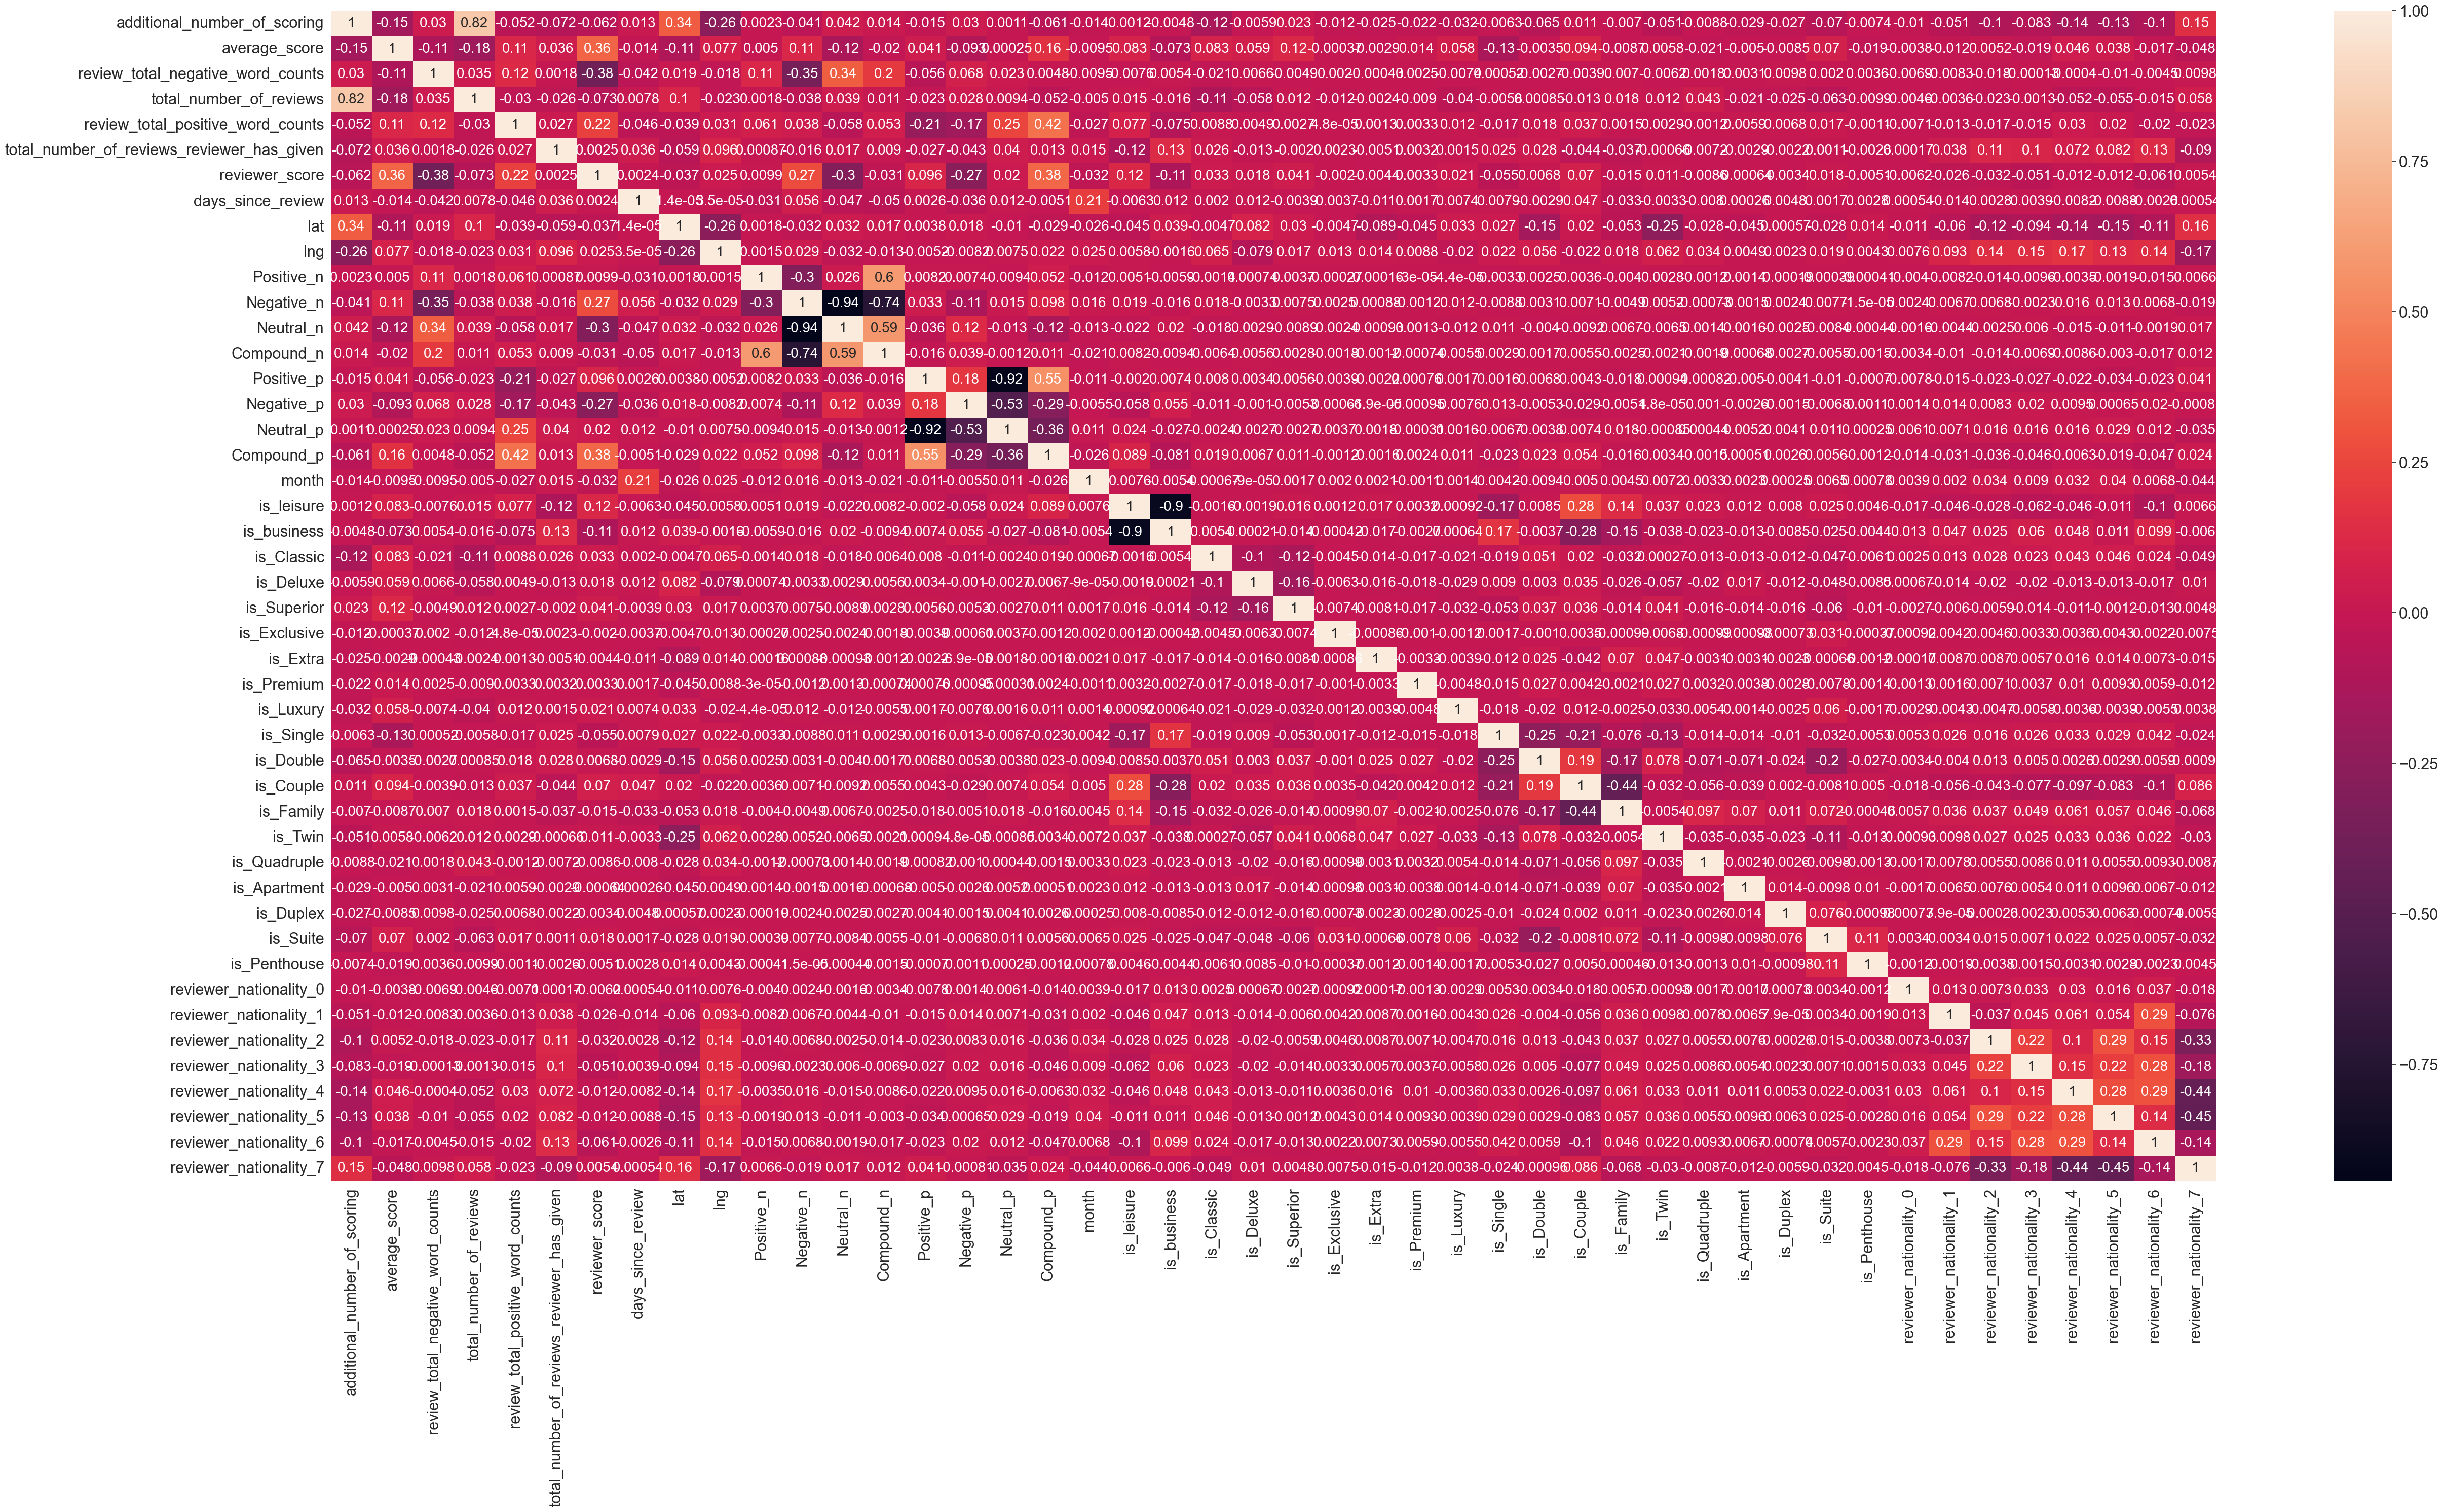

In [20]:
sns.set(font_scale=2)
plt.subplots(figsize=(60,30))
sns.heatmap(hotels.corr(numeric_only=True), annot=True, annot_kws={'size': 20})

Корреляция между признаками 'Negative_n' и  'Neutral_n' составила 0.94. При отборе признаков один из них необходимо удалить.

Корреляция между признаками 'Positive_p' и  'Neutral_p' составила 0.92. При отборе признаков один из них необходимо удалить.

In [21]:
# удаляем признаки 'Neutral_n' и 'Neutral_p'
hotels = hotels.drop('Neutral_n', axis=1)
hotels = hotels.drop('Neutral_p', axis=1)

In [23]:
# Снова сохраняем обработанный датасет
hotels.to_csv('data/hotels_new_02.csv', index=False, header=True)

5. Реализация машинного алгоритма и проверка его эффективности. 

In [ ]:
# убираем признаки которые еще не успели обработать, 
# модель на признаках с dtypes "object" обучаться не будет, просто выберем их и удалим
object_columns = [s for s in hotels.columns if hotels[s].dtypes == 'object']
hotels.drop(object_columns, axis = 1, inplace=True)

In [30]:
# удаляем признак в формате datetime 
hotels = hotels.drop('review_datetime', axis=1)

In [36]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = hotels.drop(['reviewer_score'], axis = 1)  
y = hotels['reviewer_score'] 

In [37]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, 
# "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [38]:
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  

In [39]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), 
# и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) 
# и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.12515293033160207


<Axes: >

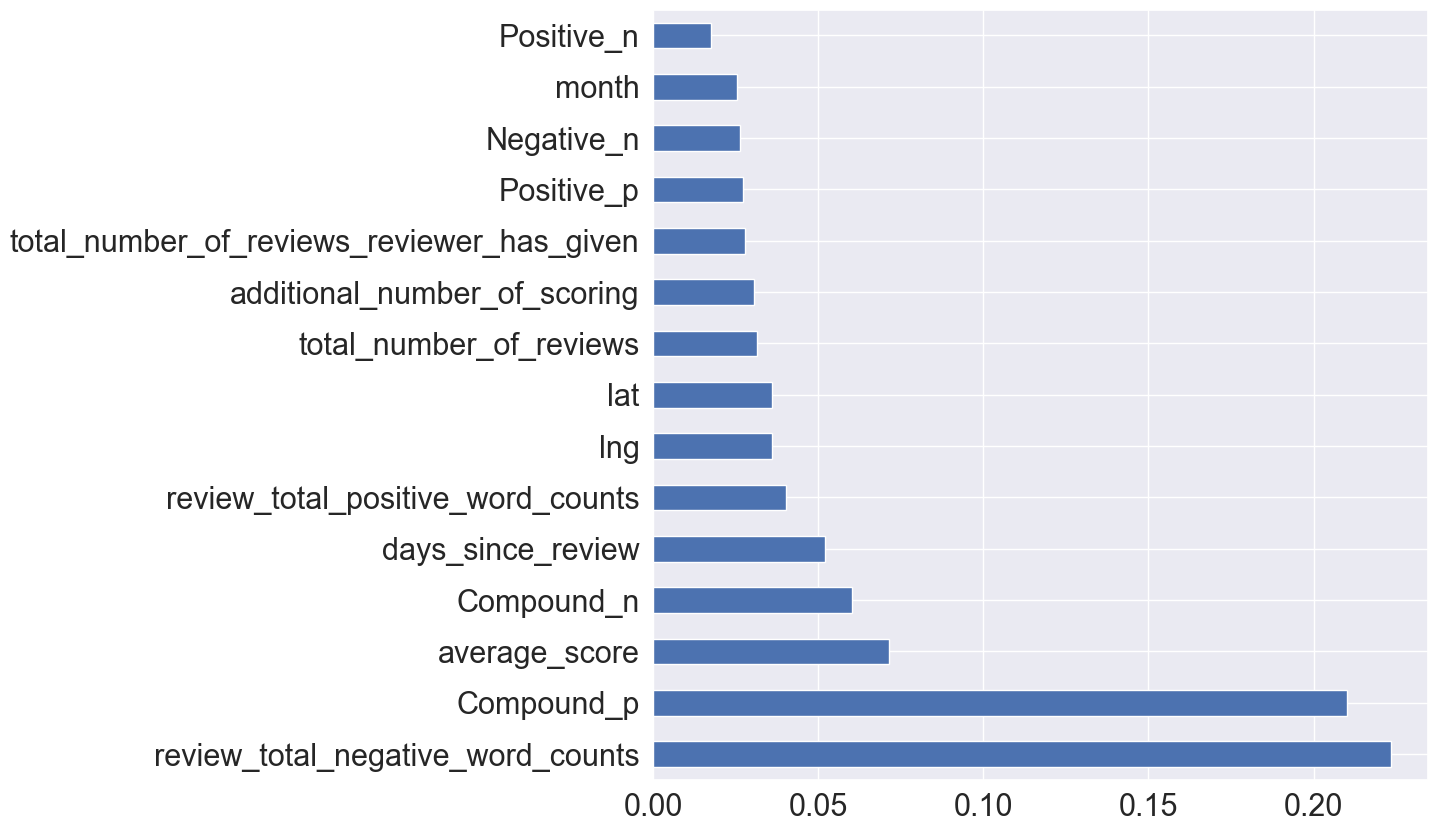

In [41]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [86]:
# Удаляем 24 наименее важных признаков (оставляем 20 признаков для модели)
drop_cols = feat_importances.nsmallest(24)
drop_list = drop_cols.index.to_list()
hotels = hotels.drop(columns=drop_list)

In [88]:
# Снова создаём модель 
X = hotels.drop(['reviewer_score'], axis = 1)  
y = hotels['reviewer_score'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

regr = RandomForestRegressor(n_estimators=100)  

regr.fit(X_train, y_train)  
      
y_pred = regr.predict(X_test)  

print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.12574323794929068


Метрика модели, обученной на 44 признаках: MAPE: 0.12515293033160207

Метрика модели, обученной на самых важных 20 признаках: MAPE: 0.12574323794929068

Метрика изменилась незначительно.